### Here you compare n interactions between conditions (of a certain type)

##### this can let you know how well a ligand is interacting with the protein, for instance

In [1]:
import numpy as np
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import prolif as plf
import MDAnalysis as mda
import pandas as pd
import src.analysis_functions as analysis_functions
import seaborn as sns
from typing import Optional
import src.simulation_metadata as sims

In [2]:
sim_list = [sims.PfHT_MMV12, sims.PfHT_MMV8, sims.W412A_MMV12, sims.GLUT1_MMV12]

color_l = [sim.color for sim in sim_list]

all_unis, all_lens = analysis_functions.load_unis(
    sim_list= sim_list
)


In [3]:
all_fp_dfs = {}
skip = 1

for sim in sim_list:
    temp_fp_dfs = []
    for n, rep_fp in enumerate(all_unis[sim.name]):
        df = analysis_functions.get_fp_dataframe(
            u=rep_fp,
            skip=skip,
            run_calc=False,
            filename=f"{sim.name}.replica_{n+1}.skip{skip}",
        )
        temp_fp_dfs.append(df)
    all_fp_dfs[sim.name] = temp_fp_dfs


## Two ways of doing the n_interactions.
1. Count the values yourself using `value_counts` = True
   - This will count the values for you, and return a short df with the counts of each interaction. You can just put this in a bar graph. This is the first ex below
   - Using a percentage is better here
2. Use a histogram method for sns, therefore **not** using `value_counts`
   - KDE is good for visualizing overlaying data

#### method 1 - bar graph

In [96]:
intxn_name='HBAcceptor'

In [101]:
n_intxns_wide = analysis_functions.pct_n_intxn_per_frame_wide(
    sims=sim_list,
    intxn_name=intxn_name,
    all_fp_dfs=all_fp_dfs,
    value_counts=True,
    percentage=True
)


n_intxns = analysis_functions.process_wide_df(
    df=n_intxns_wide, 
    index_col_name="n_interactions",
    condition_to_remove=None,
    index_name="n_interactions",
    top_level_melt_name="protein",
    lower_level_melt_name="replica",
    add_21=False,
)



Text(0.5, 0, 'Number of interactions per frame')

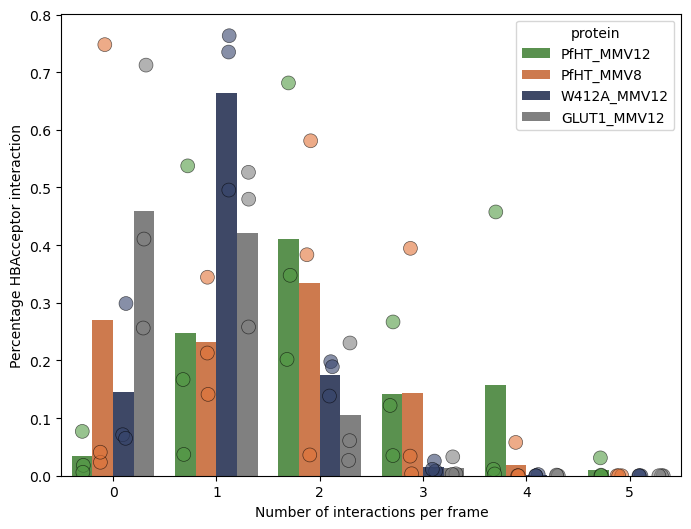

In [103]:
f, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.barplot(
    data=n_intxns,
    x="n_interactions",
    y="value",
    hue="protein",
    errorbar=None,
    ax=ax,
    palette=color_l,
)

sns.stripplot(
    data=n_intxns,
    x="n_interactions",
    y="value",
    hue="protein",
    ax=ax,
    dodge=True,
    alpha=0.6,
    edgecolor="black",
    linewidth=0.5,
    legend=False,
    size=10,
    palette=color_l,
)

ax.set_ylabel(f"Percentage {intxn_name} interaction")
ax.set_xlabel("Number of interactions per frame")
# ax.set_ylim(0,1.1)


Ok here is a quick and dirty way to also look at the distribution

Just calculating mean and std across replicas, and then plot them. Using the wide format for now because I am not sure how to make this so smoothly with the long

In [104]:
n_intxns_wide

PfHT_MMV12                     PfHT_MMV8                      \
                replica 1 replica 2 replica 3 replica 1 replica 2 replica 3   
n_interactions                                                                
2                0.681319  0.201798  0.347652  0.036036  0.383333  0.580974   
1                0.166833  0.036963  0.537463  0.212838  0.141111  0.344281   
3                0.121878  0.266733  0.034965  0.003378  0.394444  0.033975   
0                0.017982  0.005994  0.076923  0.747748  0.023333  0.040770   
4                0.010989  0.457542  0.002997       NaN  0.057778       NaN   
5                0.000999  0.030969       NaN       NaN       NaN       NaN   

               W412A_MMV12                     GLUT1_MMV12                      
                 replica 1 replica 2 replica 3   replica 1 replica 2 replica 3  
n_interactions                                                                  
2                 0.138211  0.197802  0.189038    0.026461  0.060819  0.230248  
1                 0.763211  0.495504  0.734899    0.257993  0.526316  0.479684  
3                 0.025407  0.007992  0.011186    0.003308  0.002339  0.032731  
0                 0.071138  0.298701  0.064877    0.712238  0.410526  0.256208  
4                 0.002033       NaN       NaN         NaN       NaN  0.001129  
5                      NaN       NaN       NaN         NaN       NaN       NaN

Text(0, 0.5, 'Proportion of simulation')

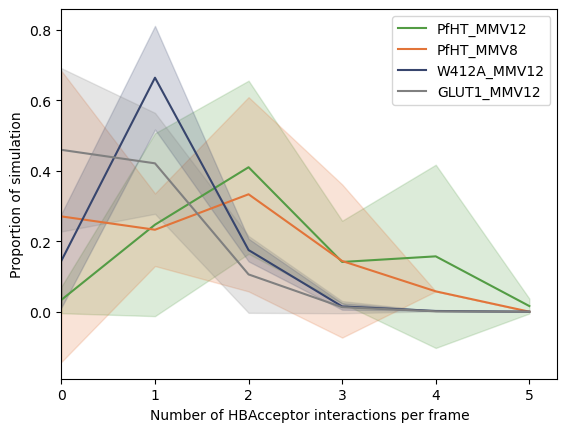

In [107]:
mean_df = []
std_df = []
for sim in sim_list:
    std_intxns=n_intxns_wide[sim.name].std(axis=1)
    mean_intxns=n_intxns_wide[sim.name].mean(axis=1)
    mean_df.append(mean_intxns)
    std_df.append(std_intxns)
mean_df = pd.concat(mean_df, axis=1)
mean_df.columns=[sim.name for sim in sim_list]
mean_df = mean_df.sort_index()
mean_df = mean_df.fillna(value=0)

std_df = pd.concat(std_df, axis=1)
std_df.columns=[sim.name for sim in sim_list]
std_df = std_df.sort_index()
std_df = std_df.fillna(value=0)


f,ax=plt.subplots(1,1)

for sim in sim_list:
    ax.plot(mean_df[sim.name].index,
            mean_df[sim.name],
              label=sim.name,
              color=sim.color
              )
    ax.fill_between(mean_df[sim.name].index,
                     mean_df[sim.name]-std_df[sim.name],
                     mean_df[sim.name]+std_df[sim.name],
                     color=sim.color,
                     alpha=0.2)
  
ax.legend()
ax.set_xlim(0,max(mean_df.index)+0.3)
ax.set_xlabel(f'Number of {intxn_name} interactions per frame')
ax.set_ylabel("Proportion of simulation")


#### Method 2 - Let sns do histogramming for you

This requires that `value_counts` is `False` (same with `percentage`). This will then only take the sum of the interactions across the dataframe.


This also means that the index that you reset and melt onto will be called `frame`, since `value_counts` = False

In [19]:
n_intxns_wide = analysis_functions.pct_n_intxn_per_frame_wide(
    sims=sim_list,
    intxn_name=intxn_name,
    all_fp_dfs=all_fp_dfs,
    value_counts=False,
    percentage=False
)


n_intxns_wide = analysis_functions.process_wide_df(
    df=n_intxns_wide, 
    index_col_name="n_interactions",
    condition_to_remove=None,
    index_name="frame",
    top_level_melt_name="protein",
    lower_level_melt_name="replica",
    add_21=False,
)


"\nsns.stripplot(data=n_intxns, \nx='n_interactions',\ny='value',\nhue= 'protein',\nax= ax,\ndodge=True,\nalpha= 0.6,\nedgecolor='black',\nlinewidth=0.5,\nlegend=False,\nsize=5,\npalette= color_l\n)\n"

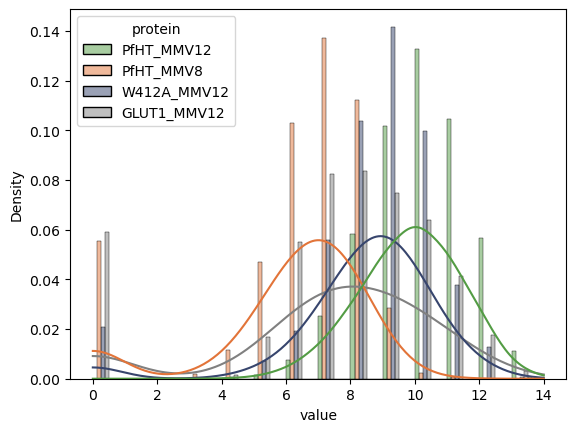

In [20]:
f, ax = plt.subplots(1, 1)
sns.histplot(
    data=n_intxns_wide,
    x="value",
    hue="protein",
    palette=color_l,
    stat="density",
    kde_kws={"bw_adjust": 2},
    element="bars",
    binwidth=0.5,
    multiple="dodge",
    ax=ax,
    kde=True,
)
"""
sns.stripplot(data=n_intxns, 
x='n_interactions',
y='value',
hue= 'protein',
ax= ax,
dodge=True,
alpha= 0.6,
edgecolor='black',
linewidth=0.5,
legend=False,
size=5,
palette= color_l
)
"""

## TODO - still not sure how to include replicas in this graph. Need to tinker
